<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/mlps/AK_MM_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will do the following things:

We are creating a neural network that takes 3 characters (with an embedding dimension of 10) and predicts the 4th with names.txt as dataset

*   Create a train/test/dev dataset from names.txt
*   Create a neural net with the following architecture
  * 2 Layers (n_hidden=200), Tanh as non-linearity
  * add custom batchnormalisation and weight initialisation techniques
  * Plot the Tanh saturation (with and without the above techniques)
* Create a neural net with from separate layer modules
  * 6 Linear layers (n_hidden=200), Tanh as non-linearity (without and with batchnorm)
  * add the following histogram plots
    * forward pass activations (layer.out)
    * backward pass activations (layer.out.grad)
    * parameter.grad (and parameter.grad /parameter.data ratio)
    * parameter update/parameter.data ratio

    
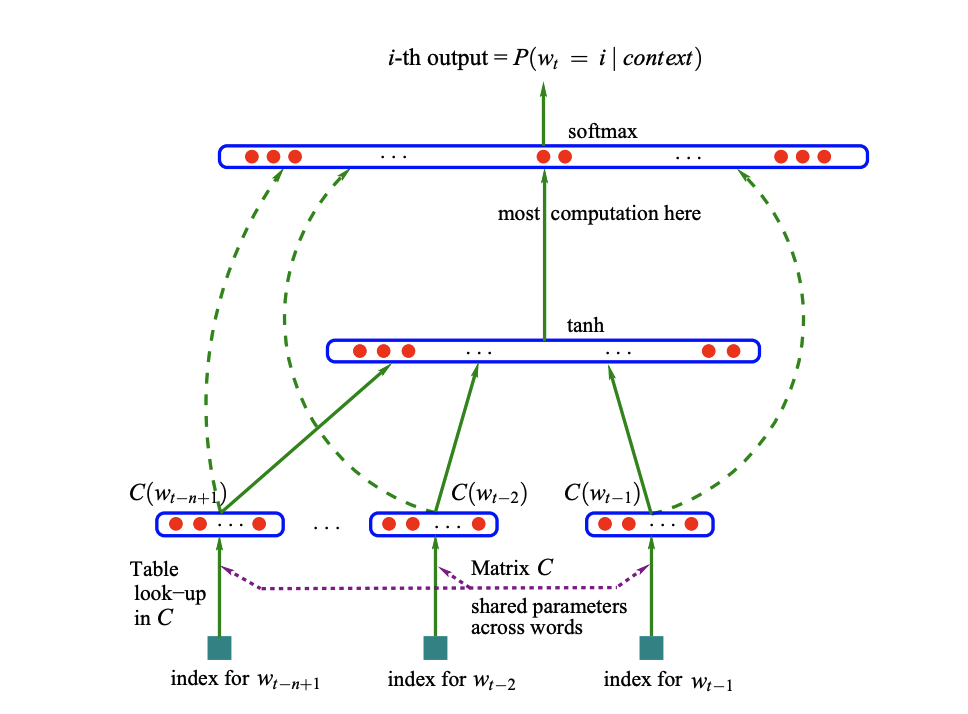






In [1]:
import torch
import torch.nn.functional as F

In [2]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
words = open("/content/drive/MyDrive/Data/AK/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# ITOS and STOI
chars = sorted(list(set("".join([word for word in words]))))
itos = {i+1 : char for i,char in enumerate(chars)}
itos[0] = "."
stoi = {char : i for i, char in itos.items()}
vocab_size = len(itos)

In [5]:
# BUILDING THE DATASET
block_size = 3

x = []
y = []

for word in words:

  context = [0] * block_size
  for char in word + ".":
    x.append(context)
    ix = stoi[char]
    context = context[1:] + [ix]
    y.append(ix)

X = torch.tensor(x)
Y = torch.tensor(y)

import random
seed = 42
random.Random(seed).shuffle(X)
random.Random(seed).shuffle(Y)
dev_index = int(0.8 * len(X))
test_index = int(0.9 * len(X))

Xdev = X[dev_index:test_index]
Ydev = Y[dev_index:test_index]

Xtest = X[test_index:]
Ytest = Y[test_index:]

Xtr = X[:dev_index]
Ytr = Y[:dev_index]

In [6]:
Xdev.shape, Xtest.shape, Xtr.shape

(torch.Size([22815, 3]), torch.Size([22815, 3]), torch.Size([182516, 3]))

In [7]:
Ydev.shape, Ytest.shape, Ytr.shape

(torch.Size([22815]), torch.Size([22815]), torch.Size([182516]))

In [8]:
# CREATE MLP

# Usually you want to think about fixing:
# * the initial loss => DIVIDE by SQRT of fan_in
# * the initialisation of the weights (and biases)
# * the input/out distribution of the activation (should be roughly Gaussian)

n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
bngain = torch.ones(1,n_hidden)
bnbias = torch.zeros(1, n_hidden)
bn_running_mean = torch.zeros((1, n_hidden))
bn_running_std = torch.ones((1, n_hidden))

parameters = [W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [9]:
# TRAIN THE MLP

n_epochs = 3000
batch_size = 32
learning_rate = 0.001
lossi = torch.zeros(n_epochs)

for it in range(n_epochs):
  # take a batch
  idx = torch.randint(0, Xtr.shape[0], (32,), generator=g)
  X_b = Xtr[idx]
  Y_b = Ytr[idx]
  emb = C[X_b]
  hpreact = emb.view(32,-1) @ W1 + b1

  bmeani = hpreact.mean(0, keepdim=True)
  bstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bmeani) / bstdi + bnbias

  with torch.no_grad():
    bn_running_mean = 0.999 * bn_running_mean + 0.001 * bmeani
    bn_running_std = 0.999 * bn_running_std + 0.001 * bstdi

  hreact = torch.tanh(hpreact)
  logits = hreact @ W2 + b2
  loss = F.cross_entropy(logits, Y_b)
  optimizer = torch.optim.Adam(params=parameters, lr=learning_rate)

  # zero grad optimizer
  for p in parameters:
    p.grad = None

  loss.backward()

  # step optimizer
  for p in parameters:
    p.data += -learning_rate * p.grad

  optimizer.step()

  lossi[it] = loss.item()

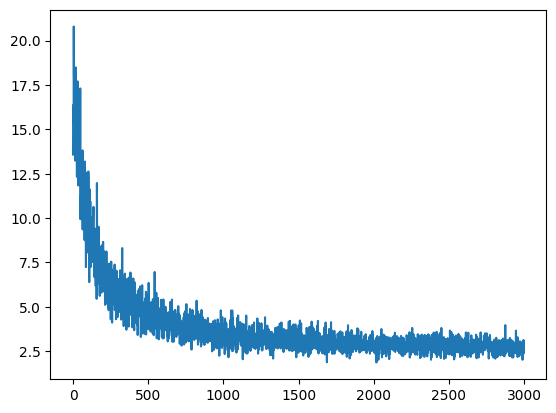

In [10]:
# PLOTTING THE LOSS, ACTIVATION SATURATION AND ACTIVATION DISTRIBUTION

import matplotlib.pyplot as plt
plt.plot(lossi)

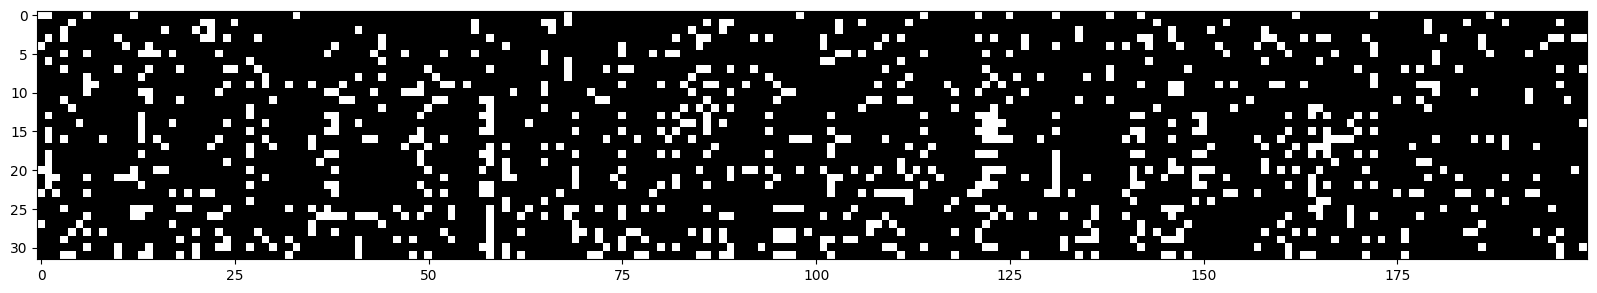

In [11]:
# Plot tanh saturation - NO FIXING
plt.figure(figsize=(20,10))
plt.imshow(hpreact.abs() > 0.99, cmap="gray", interpolation="nearest")

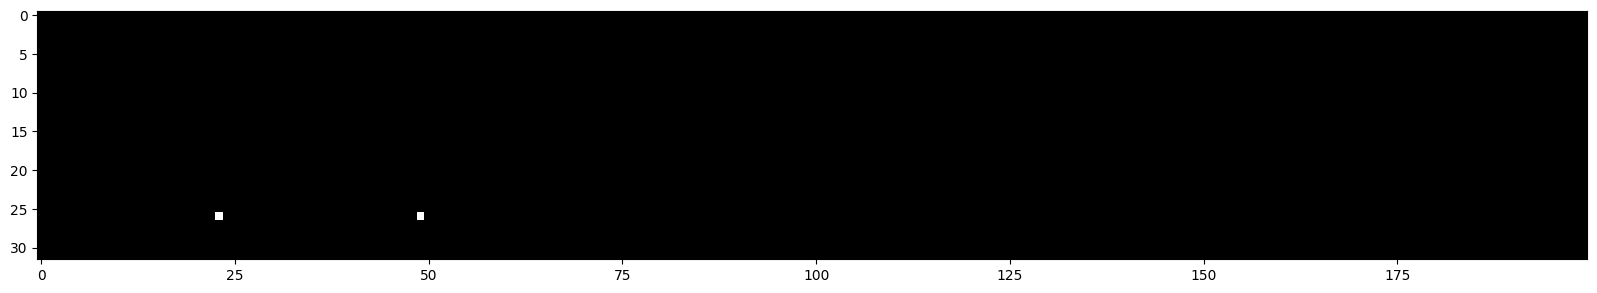

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(hreact.abs() > 0.99, cmap="gray", interpolation="nearest")

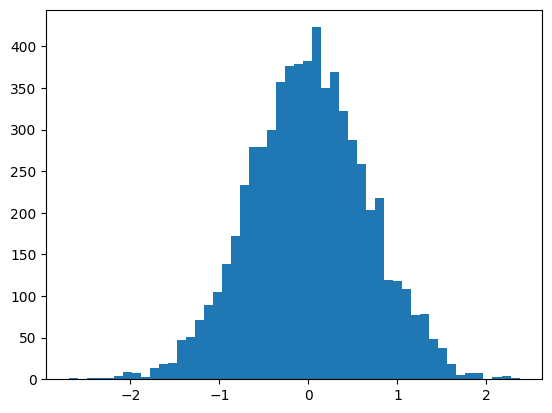

In [13]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

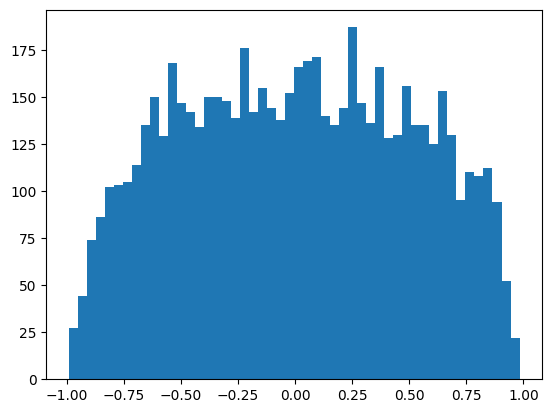

In [14]:
plt.hist(hreact.view(-1).tolist(), bins=50);

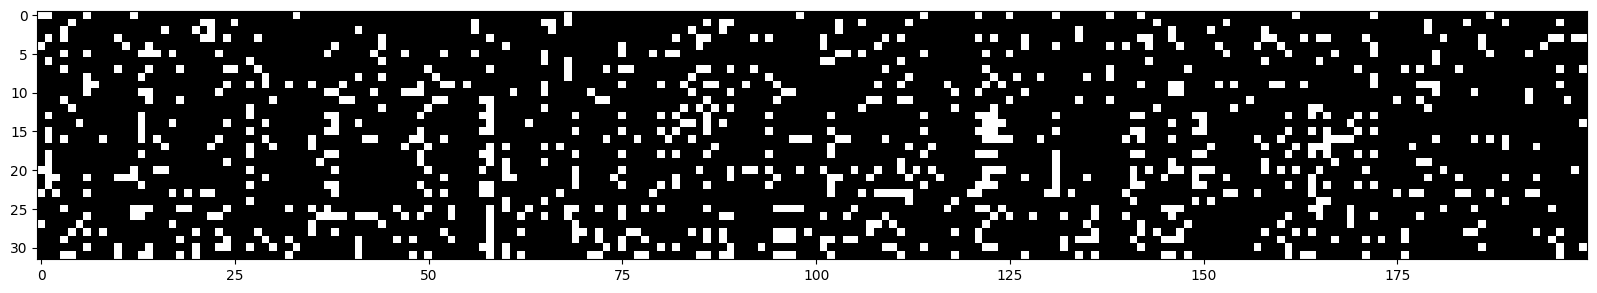

In [15]:
# Plot tanh saturation - FIXING IN PLACE
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(hpreact.abs() > 0.99, cmap="gray", interpolation="nearest")

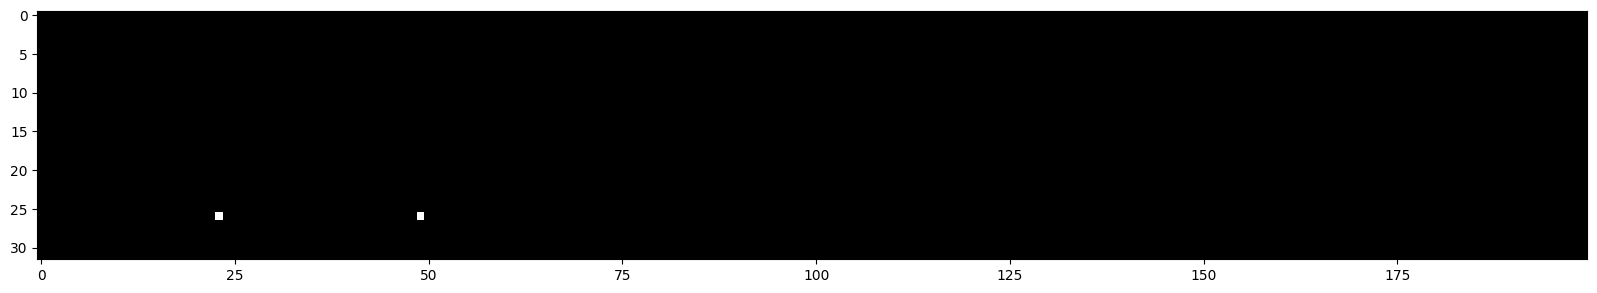

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(hreact.abs() > 0.99, cmap="gray", interpolation="nearest")

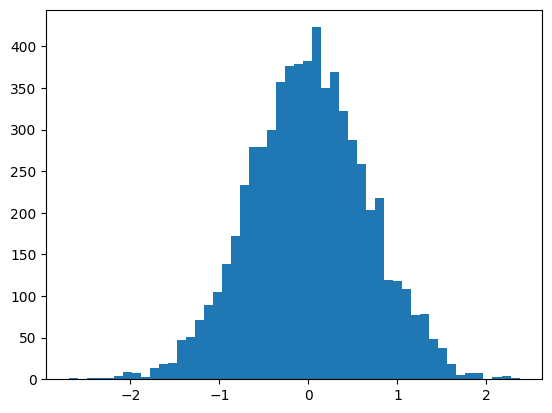

In [17]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

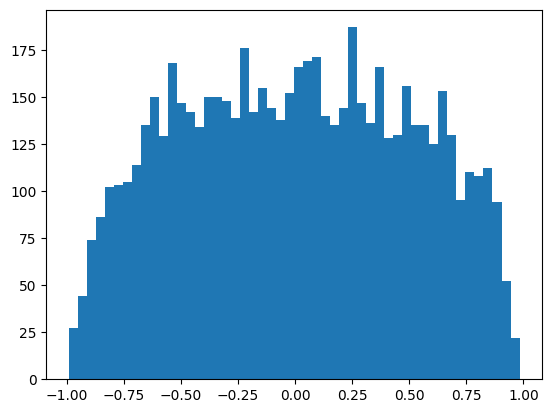

In [18]:
plt.hist(hreact.view(-1).tolist(), bins=50);

In [63]:
# CREATE LAYER MODULES

class Linear:

  def __init__(self, fan_in, fan_out, generator, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=generator) / (fan_in)**0.5
    self.bias = torch.zeros(fan_out) if bias else None
    self.out = None

  def __call__(self, x):
    x = x @ self.weight
    if self.bias is not None:
      x = x + self.bias

    self.out = x

    return x

  def parameters(self):
    return [self.weight, self.bias]


class BatchNorm1D:

  def __init__(self, dim, epsilon=1e-5, momentum=0.001, affine=True):
    self.bngain = torch.ones(dim)
    self.bnbias = torch.zeros(dim)
    self.epsilon = epsilon
    self.momentum = momentum
    self.affine = affine
    self.out = None
    self.training = True
    self.bnrunning_var = torch.ones(dim)
    self.bnrunning_mean = torch.zeros(dim)

  def __call__(self, x):
    if self.training:
      bmeani = x.mean(0, keepdim=True)
      bvari = x.var(0, keepdim=True)
    else:
      bmeani = self.bnrunning_mean
      bvari = self.bnrunning_var

    x = self.bngain * (x - bmeani) / (bvari + self.epsilon)**0.5 + self.bnbias

    if self.training and self.affine:
      with torch.no_grad():
        val = 1 - self.momentum
        self.bnrunning_mean = val * self.bnrunning_mean + self.momentum * bmeani
        self.bnrunning_var = val * self.bnrunning_var + self.momentum * bvari

    self.out = x

    return x

  def parameters(self):
    return [self.bngain, self.bnbias] if self.affine else []


class Tanh:

  def __init__(self):
    self.out = None

  def __call__(self, x):
    x = torch.tanh(x)

    self.out = x

    return x

  def parameters(self):
    return []


In [64]:
# CREATE THE NEURAL NETWORK FROM LAYERS
layers = [
    Linear(fan_in=n_embed*block_size, fan_out=n_hidden, generator=g), BatchNorm1D(dim=n_hidden), Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=g), BatchNorm1D(dim=n_hidden), Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=g), BatchNorm1D(dim=n_hidden), Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=g), BatchNorm1D(dim=n_hidden), Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=g), BatchNorm1D(dim=n_hidden), Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, generator=g)
]

with torch.no_grad():
  # last layer: make less confident:
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

C = torch.randn((vocab_size, n_embed), generator=g)

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for param in parameters:
  param.requires_grad = True

In [87]:
# same optimizations as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1) # embed the characters into vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  for layer in layers:
    layer.out.retain_grad()
  loss.backward()

  optimizer = torch.optim.Adam(parameters)
  lr=0.01 if max_steps < 100000 else 0.001
  for param in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f"Epoch: {i}/|{max_steps}. Loss: {loss.item():.4f}")
  lossi.append(loss.item())

  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 6000:
    break

Epoch: 0/|200000. Loss: 3.2944


layer 2 (      Tanh): mean -0.01, std 0.62, saturated: 3.59%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 3.06%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.86%
layer 11 (      Tanh): mean +0.00, std 0.63, saturated: 3.05%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%


Text(0.5, 1.0, 'activation distribution')

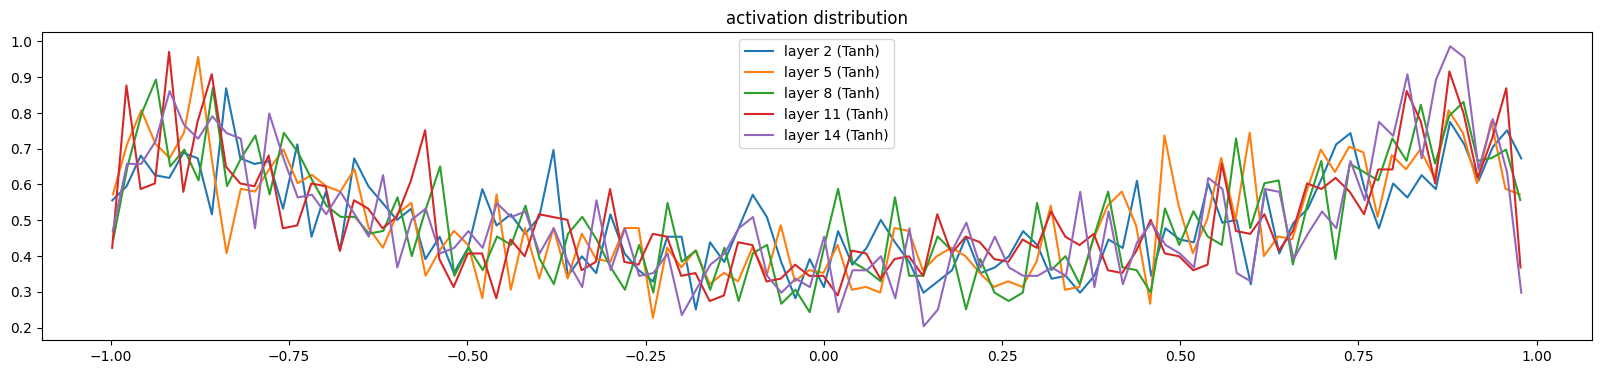

In [88]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

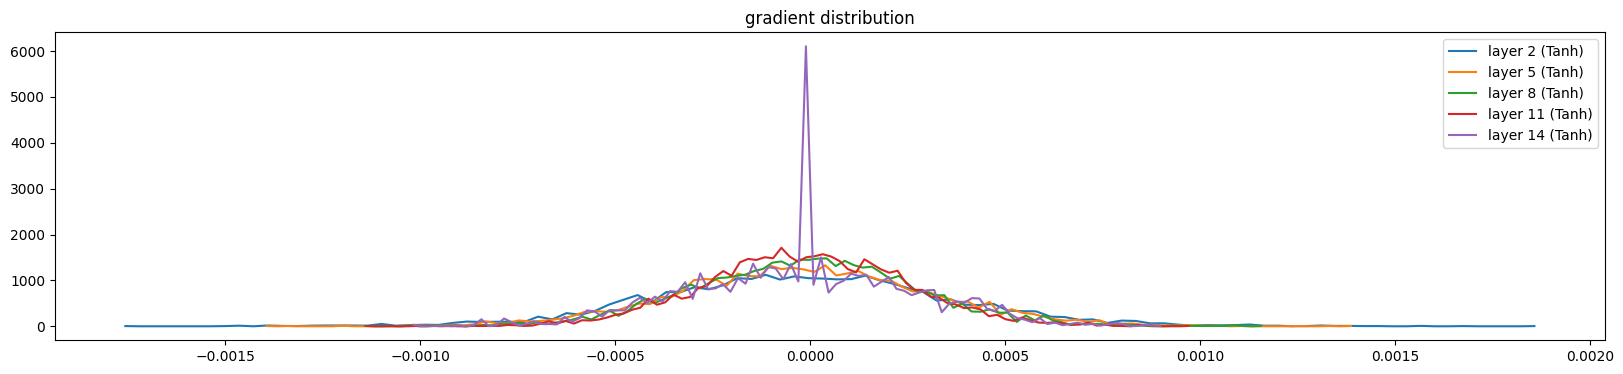

In [89]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 1.389155e+00 | grad:data ratio 1.437235e+00
weight  (30, 200) | mean 0.001764 | std 1.506324e+00 | grad:data ratio 4.917311e+00
weight (200, 200) | mean -0.006097 | std 1.402938e+00 | grad:data ratio 1.190785e+01
weight (200, 200) | mean 0.004192 | std 1.259668e+00 | grad:data ratio 1.068961e+01
weight (200, 200) | mean -0.004518 | std 1.131627e+00 | grad:data ratio 9.563963e+00
weight (200, 200) | mean 0.004710 | std 1.086291e+00 | grad:data ratio 9.190302e+00
weight  (200, 27) | mean -0.000000 | std 4.741492e+01 | grad:data ratio 6.764847e+03


Text(0.5, 1.0, 'weights gradient distribution')

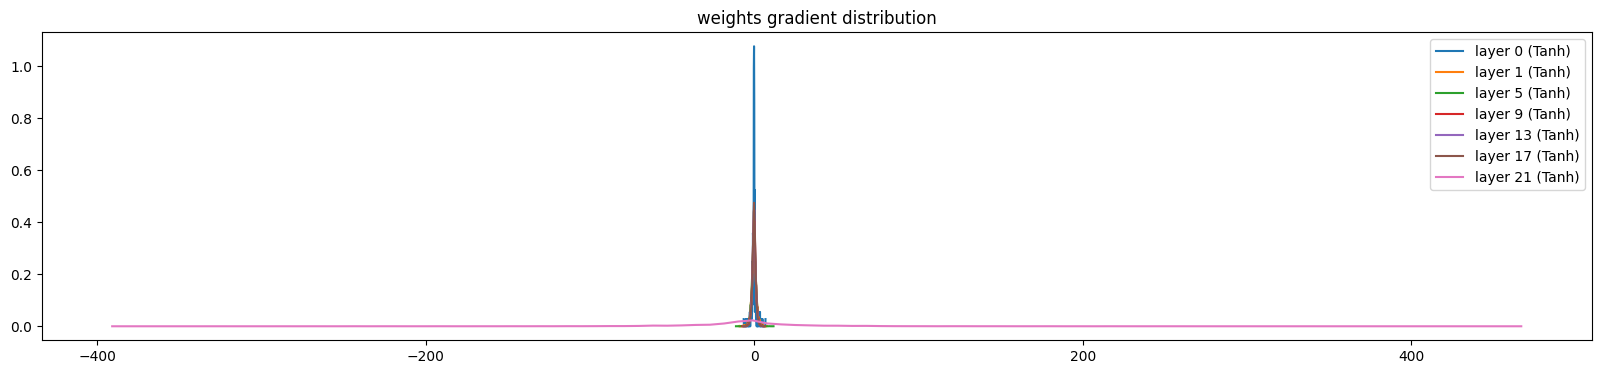

In [90]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): # note: exclude the output layer
  t = p.grad
  if p.ndim == 2:
    print("weight %10s | mean %f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("weights gradient distribution")

Text(0.5, 1.0, 'Update to data ratio')

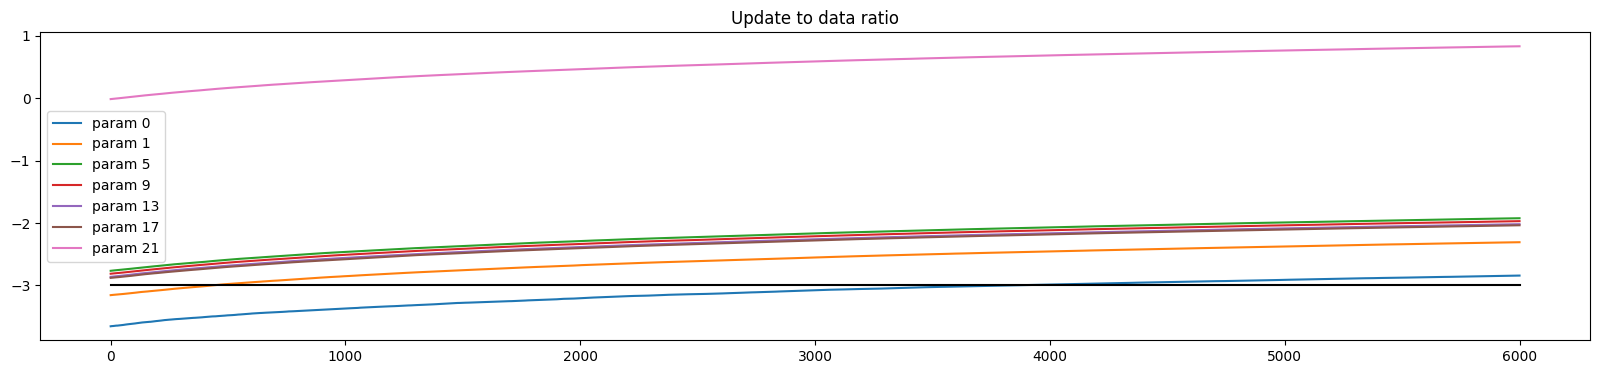

In [91]:
# visaulize histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): # note: exclude the output layer
  if p.ndim == 2:
    ls = [ud[j][i] for j in range(len(ud))]
    plt.plot(ls)
    legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3,-3], "k") # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title("Update to data ratio")

In [97]:
# Sample form the model
def sample_from_model(input):
  encoded_chars = torch.tensor([stoi[char] for char in input])
  emb = C[encoded_chars]
  x = emb.view(emb.shape, -1)
  x_unbatched = x.view(1, -1)
  print(x_unbatched)
  with torch.no_grad():
    for layer in layers:
      x_unbatched = layer(x_unbatched)

  # TODO: not working needs investigationn
  print(x_unbatched)
  probs = F.softmax(x_unbatched, dim=1)
  print(probs)
  print(probs.shape)

sample_from_model("abc")

tensor([[ 0.2153, -0.4382, -1.7077,  1.3631, -0.1491,  1.0601,  1.1655,  1.0714,
          0.0397, -0.8335, -1.5479,  0.0617, -0.0176,  1.4671,  1.2176,  1.0543,
          0.1776,  0.4508, -0.8570,  0.3702, -1.3617, -1.4794, -1.1758, -0.0615,
         -0.2491, -0.8429, -0.2387, -0.1678,  0.9847, -0.4615]],
       grad_fn=<ViewBackward0>)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]])
torch.Size([1, 27])


<ipython-input-63-dd05c92ce35b>:39: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  bvari = x.var(0, keepdim=True)


In [98]:
# Open questions
# * p.grad dimensionality ?